In [1]:
import adddeps
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from scipy.stats import norm,normaltest, probplot

import pandas as pd
import sqlalchemy
from collections import defaultdict
# from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, IntSlider
import datetime
import importlib
from simulator import SimulatorMagnetic, SimulatorLennard
from simulator.models import Client, SimulationAlchemy as Simulation
from tqdm import tqdm

import multiprocessing
from multiprocessing import Pool, cpu_count

import logging.config
import logging
import sys, os
matplotlib.rcParams["figure.dpi"] = 150
client = Client()

In [2]:
from settings import HDF5_PATH
import h5py

In [64]:
query = (session.query(Simulation.id, Simulation.particles, Simulation.E_init, Simulation.hash)
                 .where(Simulation.group_name.in_(['BO 3.lammps']))
                 .order_by(Simulation.start_time)).all()[:]
print(len(query))
print(sorted(set([x for _, x, _, _ in query])))

418
[55, 277, 469, 685, 907, 1099, 1261, 1509, 1707, 1935, 2169, 2397, 2523, 2733, 2949, 3123, 3339, 3525, 3717, 4005, 4215]


In [83]:
(session.query(Simulation.hash)
                 .where(Simulation.group_name.in_(['BO 3.lammps']))
                 .where(Simulation.particles==4215)
                 .order_by(Simulation.start_time)).all()[:]

[('4b2eb7b538bf20bc',),
 ('81704aa4058f64a6',),
 ('181dae50d8726fd6',),
 ('3c80bb7639556701',),
 ('2ffc2bed3717cb53',),
 ('7662e93fe4d16a7c',),
 ('569fcb20a402bead',),
 ('776ff3cfc9adbce7',),
 ('551f7c88a04e6e90',),
 ('8b88ac97d22957be',),
 ('1a05f24dbfd34ef4',),
 ('ca8a07e5b9639078',),
 ('a8c52d80b3fe6e02',),
 ('128ec2a630c61f08',),
 ('37489f3d24c2265f',),
 ('05960ef3b7e18dc9',),
 ('6525cafcabeaeb1a',),
 ('0ffed6b5759d7c6a',),
 ('100b35b89afe3ada',),
 ('ab77c46108eb0799',)]

In [65]:
errors = []
import json
def f(hash_):
    global errors
    file_path = os.path.join("/data/biophys/ashmat/LJ-magnetic/subresults", f"bo.{hash_}.hdf5.json")
    if os.path.exists(file_path):
        try:
            with open(file_path, "r") as f:
                datum = json.load(f)
                return datum
        except Exception as e:
            errors.append((file_path, e))

In [66]:
f(query[0][-1])

{'omega_MLE': -1.5921784398793738e-07,
 'beta_MLE': 3.0469584748709857,
 'N': 55.0,
 'L': -5.864820800782766e-06,
 'L_init': -8.881784197001252e-16,
 'E_init': 54.995840832096775,
 'E': 55.00418629999999,
 'E_end': 54.73816197199999,
 'alpha': 1.0,
 'xx': 0.33737523429081473,
 'yy': 0.3323556568620734,
 'zz': 0.02141846051202286,
 'KE': 0.4922942080366579,
 'PE': 0.5062131302987165,
 'IE': -0.0021875849376276446}

In [67]:
np.random.shuffle(query)

In [68]:
retult = []
for x in tqdm(query[:]):
    retult.append(f(x[-1]))

100%|██████████| 418/418 [00:02<00:00, 158.73it/s]


In [69]:
result = [x for x in retult if x is not None]
len(result)

418

In [77]:
df = pd.DataFrame(result)
df["E_nonconserve"] = np.abs(df["E_end"]/df["E"]-1)

df = df[df["E_nonconserve"] < 0.01]
print(len(df)/len(result))

1.0


In [78]:
df

,omega_MLE,beta_MLE,N,L,L_init,E_init,E,E_end,alpha,xx,yy,zz,KE,PE,IE,E_nonconserve
0,-1.560707e-09,3.057485,2523.0,-0.000031,-5.062617e-14,2522.624994,2523.374501,2505.979728,0.295386,3.871769,3.875487,0.242710,0.490599,0.507401,-0.003236,0.006893
1,-8.224380e-09,3.058206,4215.0,-0.000375,-1.598721e-14,4214.357003,4215.641221,4186.291639,0.250000,5.417159,5.414451,0.338025,0.490484,0.507500,-0.003303,0.006962
2,-3.204347e-09,3.057711,2949.0,-0.000081,1.065814e-14,2948.558828,2949.440602,2929.049756,0.280936,4.281591,4.281822,0.268460,0.490563,0.507441,-0.003281,0.006913
3,4.222292e-09,3.057402,3339.0,0.000132,1.421085e-14,3338.497804,3339.501538,3316.489059,0.268955,4.696168,4.655037,0.292273,0.490613,0.507353,-0.003233,0.006891
4,6.734367e-09,3.059477,2397.0,0.000118,-7.105427e-15,2396.645203,2397.354292,2380.489628,0.303841,3.669500,3.663676,0.229092,0.490280,0.507695,-0.003355,0.007035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3.703041e-09,3.057043,3717.0,0.000139,0.000000e+00,3716.436728,3717.561899,3691.919957,0.258786,5.051677,5.057252,0.315082,0.490670,0.507309,-0.003215,0.006898
414,-9.462836e-09,3.057487,1707.0,-0.000096,2.842171e-14,1706.753271,1707.246399,1695.590428,0.336692,2.988386,2.984874,0.186204,0.490599,0.507436,-0.003245,0.006827
415,2.288165e-08,3.058910,907.0,0.000080,1.065814e-14,906.874566,907.125300,900.880808,0.418942,1.926144,1.934188,0.120255,0.490371,0.507617,-0.003262,0.006884
416,3.756857e-09,3.058257,4005.0,0.000157,9.947598e-14,4004.390522,4005.607828,3977.460679,0.254242,5.229748,5.230795,0.327574,0.490475,0.507470,-0.003302,0.007027


In [72]:
df["x"] = df.alpha * df.L / df.E
df["y_beta"] = 3 * df.N/df.E/df.beta_MLE
df["y_omega"] = df.omega_MLE * df.L / df.E

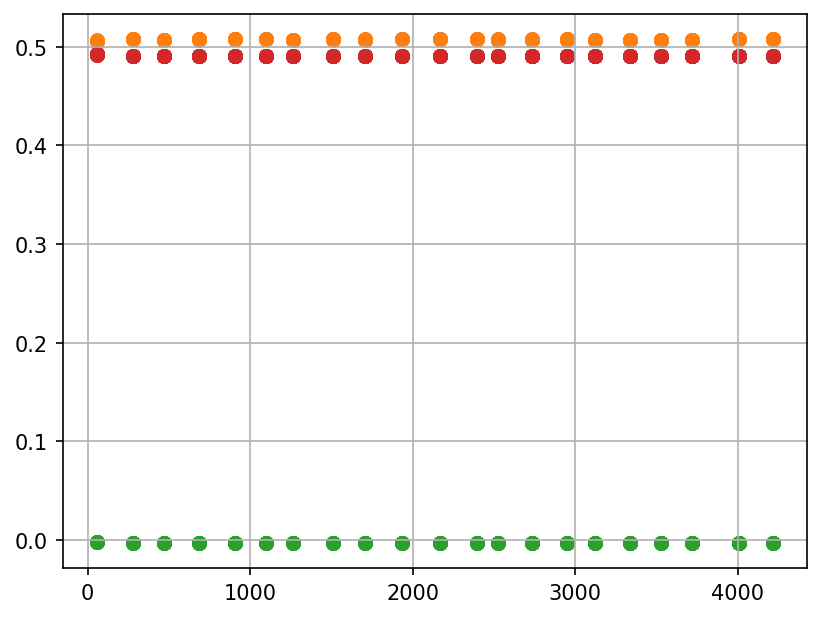

In [79]:
plt.scatter(df["N"], df["KE"])
plt.scatter(df["N"], df["PE"])
plt.scatter(df["N"], df["IE"])
plt.scatter(df["N"], (3/2)*df["beta_MLE"]**-1)
# plt.scatter(df["N"], df["zz"])

plt.grid()

In [61]:
set(df["N"])

{109.0,
 501.0,
 885.0,
 1265.0,
 1667.0,
 2003.0,
 2429.0,
 2819.0,
 3257.0,
 3569.0,
 3973.0}

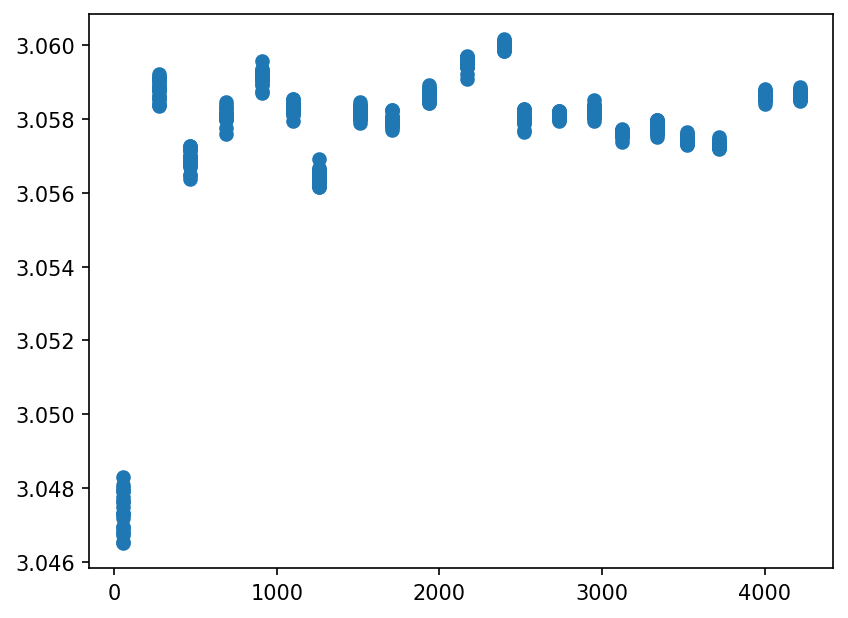

In [74]:
plt.scatter(df["N"], df["beta_MLE"] * df["E"]/df["N"])

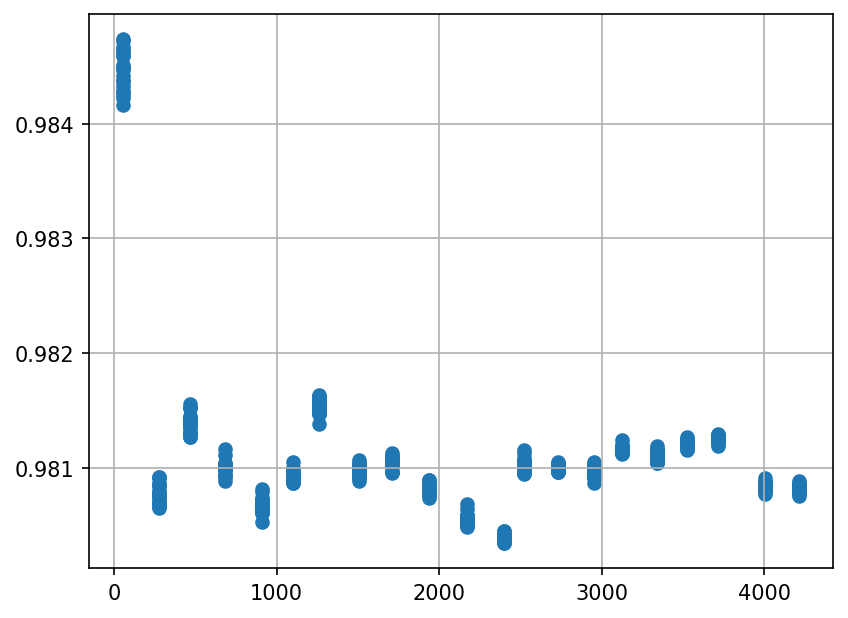

In [75]:
plt.scatter(df["N"], df["y_beta"])
plt.grid()

In [49]:
def f_beta(x):
    return 3 * (1 - x**2)/(2 + np.sqrt(1 + 3 * x**2))
def f_omega(x):
    return np.sqrt(1 + 3 * x**2) - 1

In [42]:
df[["x","y_beta","y_omega"]].to_csv("beta-omega-plot-data-ensemble-5.1.csv", index=False)

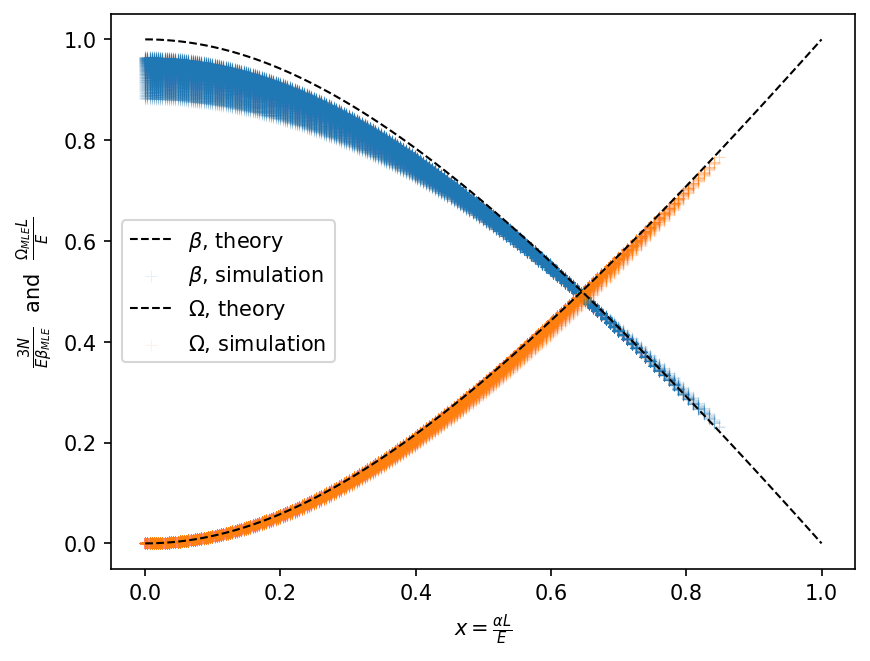

In [44]:
xs = np.linspace(0,1,100)
alpha=0.1
plt.plot(xs, f_beta(xs), "k--", lw=1, label=r"$\beta$, theory")
plt.scatter(df["x"], df["y_beta"], marker="+", s=30,lw=0.5, alpha=alpha, label=r"$\beta$, simulation")

plt.plot(xs, f_omega(xs), "k--", lw=1, label="$\Omega$, theory")
plt.scatter(df["x"], df["y_omega"], marker="+", s=30,lw=0.5, alpha=alpha, label=r"$\Omega$, simulation")


plt.xlabel(r"$x=\frac{\alpha L}{E}$")

plt.ylabel(r"$\frac{3 N}{ E \beta_{MLE} }$  and  $\frac{\Omega_{MLE} L}{E}$")
plt.legend()

In [24]:
with client.Session() as session:
    query = (session.query(Simulation.id)
                 .where(Simulation.group_name=='Ensemble 4')
                 .where(Simulation.Bz == 0)
                 .order_by(Simulation.start_time)).all()[:]
query = [x[0] for x in query]
print(len(query))

1001


In [25]:
np.random.shuffle(query)

In [26]:
sims = []
for sid in tqdm(query[:200]):
    sims.append(
        SimulatorMagnetic(id=sid)
    )

100%|██████████| 200/200 [00:00<00:00, 53676.79it/s]


In [27]:
from relaxation.estimators import RelaxationFinder

In [ ]:
RelaxationFinder(sim, tmax=50)

In [ ]:
_74.summarize()

In [20]:
data = []
rs = []
vs = []
for sim in tqdm(sims):
    start = np.searchsorted(sim.get_history()["time"], 40)
    rs.append(sim.get_history()["rs"][start:].transpose(0,2,1).reshape(-1,3))
    vs.append(sim.get_history()["vs"][start:].transpose(0,2,1).reshape(-1,3))
rs = np.concatenate(rs).T
vs = np.concatenate(vs).T

100%|██████████| 200/200 [00:06<00:00, 33.08it/s]


In [21]:
omega_MLE = np.mean(rs[0]*vs[1]-rs[1]*vs[0])/np.mean(rs[0]**2+rs[1]**2)
beta_MLE  = (1/3 * np.mean( (vs[0]+omega_MLE * rs[1])**2 + (vs[1]-omega_MLE * rs[0])**2 + (vs[2])**2) )**-1

In [22]:
omega_MLE, beta_MLE

(0.7211721, 5.182699145361456)

In [23]:
residue = beta_MLE**0.5 * np.array([
    vs[0] + omega_MLE * rs[1],
    vs[1] - omega_MLE * rs[0],
    vs[2]
])

NormaltestResult(statistic=654.0693174267558, pvalue=9.346571436511023e-143)

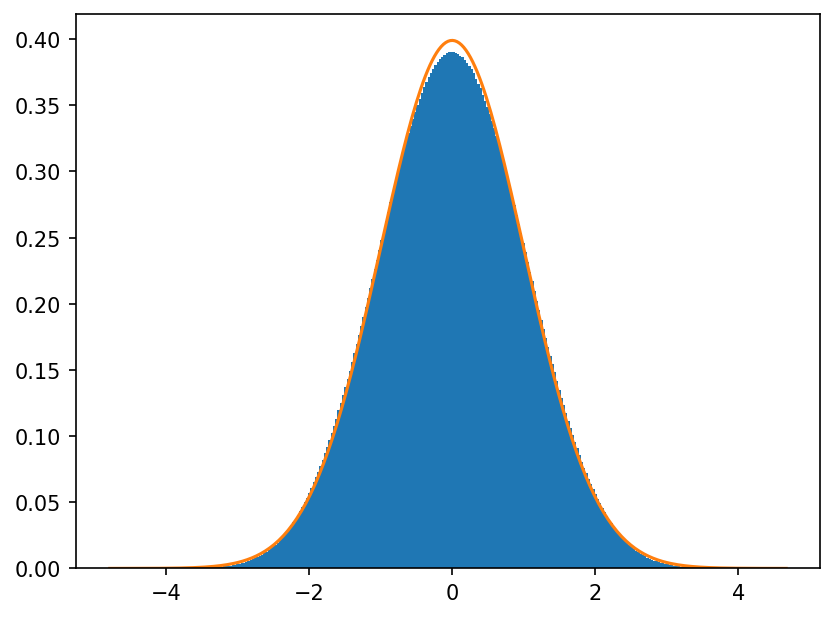

In [24]:
points = standartize(vs[0])
_,xs,_ = plt.hist(points, bins=300, density=1)
plt.plot(xs, norm.pdf(xs, loc=0, scale=1))
normaltest(residue[0])

In [27]:
points.shape

(197780600,)

In [31]:
%%time
((osm, osr), (slope, intercept, _r)) = probplot(points[::100], dist="norm",)

CPU times: user 271 ms, sys: 35.4 ms, total: 307 ms
Wall time: 302 ms


In [53]:
# plot_data = (
#     [standartize(vs[0]), standartize(vs[2]), standartize(rs[0]), standartize(rs[2]), residue[0], residue[1], residue[2]],
#     ["$v_x$", "$v_z$", "$r_x$", "$r_z$", "residue${}_x$", "residue${}_y$", "residue${}_z$"]
# )

N_ = 10**7

plot_data = (
    [np.random.choice(x, N_, replace=False) for x in 
     [standartize(vs[0]), standartize(rs[0]), residue[0]]],
    ["$v_x$", "$r_x$","residue${}_x$"]
)

In [52]:
import pickle
with open("QQ-data.pkl", "wb") as f:
    pickle.dump(plot_data, f)

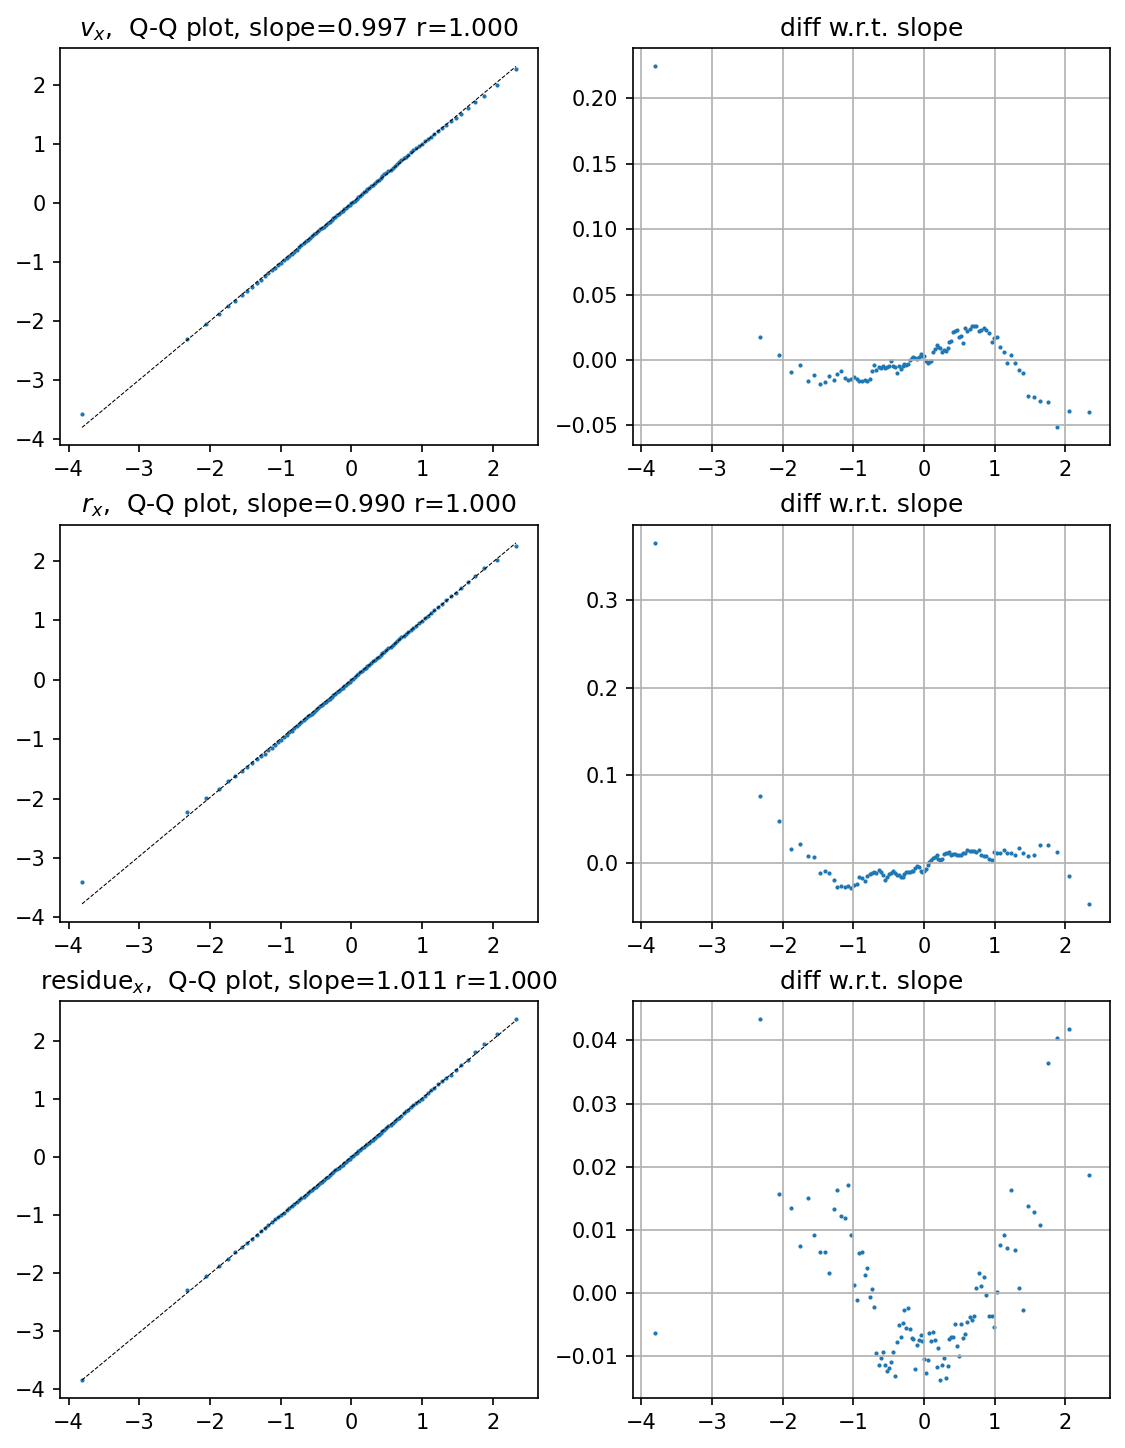

In [50]:
sp=100
n_ = len(plot_data[0])
i_ = 1
plt.figure(figsize=(8,3 * n_))
for points, title in zip(*plot_data): 
    
    ((osm, osr), (slope, intercept, _r)) = probplot(points, dist="norm",)
    
    plt.subplot(n_, 2, i_);i_+=1
    plt.scatter(osm[::sp], osr[::sp], s=1)
    plt.plot(osm[::sp], osm[::sp] * slope + intercept, ls="--", c="k", lw=0.51)
    plt.title(title+",  "+f"Q-Q plot, slope={slope:0.3f} r={_r:0.3f}");
        
    plt.subplot(n_, 2, i_);i_+=1
    plt.title("diff w.r.t. slope")
    plt.scatter(osm[::sp], osr[::sp]-(osm[::sp] * slope + intercept), s=1)
    plt.grid()

plt.subplots_adjust(bottom=0, right=1, top=1)